<a href="https://colab.research.google.com/github/HydrOpOtesJA99/A.I-learning-CNN-analysis/blob/main/CNN_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN all progress code



*   매번 돌릴떄 마다 데이터를 업로드 해야하나?
*   매번 돌릴 때 경로 확인해보기



In [1]:
# google drive를 연결(google drive에 raw data를 올려놨었음
# 웹상에서 바로 올리면 너무 늦어서 google drive에서 가져옴
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 서버 내 폴더 확인
# CNN_rawdata 폴더 생성
%cd /content/sample_data
%mkdir CNN_rawdata
%ls -lhrt

# CNN_rawdata 폴더 안으로 이동
%cd /content/sample_data/CNN_rawdata
%pwd

/content/sample_data
total 55M
-rwxr-xr-x 1 root root  930 Jan  1  2000 README.md*
-rwxr-xr-x 1 root root 1.7K Jan  1  2000 anscombe.json*
-rw-r--r-- 1 root root 1.7M Aug 31 13:47 california_housing_train.csv
-rw-r--r-- 1 root root 295K Aug 31 13:47 california_housing_test.csv
-rw-r--r-- 1 root root  35M Aug 31 13:47 mnist_train_small.csv
-rw-r--r-- 1 root root  18M Aug 31 13:47 mnist_test.csv
drwxr-xr-x 2 root root 4.0K Sep  2 04:18 CNN_rawdata/
/content/sample_data/CNN_rawdata


'/content/sample_data/CNN_rawdata'

In [ ]:
# Dataset_1_CMYK_test.zip 파일 unzip
# 현재 위치 /content/sample_data/CNN_rawdata에 unzip
!unzip /content/drive/MyDrive/CNN_practice/Dataset_1_CMYK_test.zip -d /content/sample_data/CNN_rawdata

## 1. module import

In [4]:
# numpy, pandas등 import
import numpy as np
import pandas as pd
import math
import os

# matplotlib import
import matplotlib.pyplot as plt
from datetime import datetime
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential

# Tensorflow import
import tensorflow as tf
from random import sample
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers
from keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, \
    ZeroPadding2D, Add, Dropout, Flatten, concatenate
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings

# OpenCV(Open Source Computer Vision)실시간 이미지/영상 처리에 사용하는 라이브러리
import cv2 

warnings.filterwarnings('ignore')

## 2. CNN model의 구성

In [5]:
# 그냥 2가지의 model을 만들어봄, 실제 분석에서는 2중 1개만 사용

# CNN model 1
def Func_model(tmp):
    model = Sequential() # sequential 모델(순차 모델)은 순차적으로 레이어 층을 더해준다

    model.add(Conv2D(filters=16, input_shape=(tmp[0], tmp[1], tmp[2]), kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    # filters=16: 16개의 filter 사용, # kernel_size: 2x2 크기의 filter 사용, # samepadding: 출력 크기를 입력크기와 동일하도록 padidng
    # pool_size: pooling filter size = 2

    model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(4, activation='softmax')) # 4가지로 분류되도록 함

    return model # model에 값을 반환

# cnn model 2
def Func_model_2(tmp):
    model = Sequential()

    model.add(Conv2D(filters=32, input_shape=(tmp[0], tmp[1], tmp[2]), kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    
    model.add(Flatten())
    # model.add(Dense(10, activation='softmax'))
    model.add(Dense(4, activation='softmax'))

    return model # model에 값을 반환

### 2.1 CNN model에 Optimizer 추가

In [24]:
# optimizer: 학습속도를 빠르고 안정적이게 함

from tensorflow import keras # 추가된 내용

def Func_model_opt(model, lr_): # Func_model_opt라는 함수 만듬,  # model, lr(Learning rate)_은 매개변수
    Adam = keras.optimizers.Adam(lr=lr_) # Adam(Adaptive Moment Estimation) optimizer 사용,  # Adam learning rate default = 0.001
    model.compile(optimizer=Adam, loss='categorical_crossentropy', metrics=['accuracy'])
    # Categorical_Crossentropy: label이 원-핫 인코딩 된 형태일때 사용
    return model

## 3. 결과 파일 폴더 생성

In [7]:
# 결과 파일 폴더 생성
%cd /content/sample_data
Today = datetime.today().strftime("%Y%m%d")
dir = 'CNN_practice_' + Today
if not (os.path.isdir(os.path.join(dir, 'Validation_result_'+ Today))):
    # os.path.isdir: path가 존재하는 디렉토리인 경우 True로 반환한다
    # os.path.join: 인수에 전달된 2개의 문자열을 결함하여 1개의 경로로 할 수 있다
    os.makedirs(os.path.join(dir, 'Validation_result_' + Today))
    # os.makedirs: 폴더내에 여러 하위 폴더를 만들 수 있다
    # os.mkdir: 한 폴더만 생성 가능하다
save_dir = os.path.join(dir, 'Validation_result_' + Today)
print(': Success to make folder for result file')

/content/sample_data
: Success to make folder for result file


## 4. 결과 요약(csv 파일)

In [8]:
# 결과 요약(csv 파일)
save_dir_csv = os.path.join(save_dir, 'CMYK_test_1_file_test_set.csv')
# os.path.join: 인수에 전달된 2개의 문자열을 결함하여 1개의 경로로 할 수 있다

## 5. EarlyStopping

In [9]:
# EarlyStopping # 너무 많은 Epoch에의한 overfitting을 학습의 중단을 통해 막는다
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=5)
# monitor='val_loss' : validation set의 loss를 monitoriing 한다는 뜻
# mode='auto' : default 값은 auto, keras에서 알아서 min, max를 선택하게 한다
# verbose=0 : 학습내용이 나타나지 않음, verbose=1: 학습내용이 나타남
# patience=5 : 성능이 증가하지 않는 epoch를 몇 번 허용할 것인가를 정의
acc = []

result_prob = []
dataset_dir = '/content/sample_data/CNN_rawdata'

## 6. unique 개수 확인을 위해 image 폴더 불러오기

In [10]:
# 원본이미지 shape

img = cv2.imread('/content/sample_data/CNN_rawdata/Chinese accessions/10073.png')
print(img.shape) 
# 2804 x 2804 의 크기를 가지는 컬러(3) 이미지
# 이미지 1개(10073.png)의 shape 확인하므로 (1, 2804, 2804, 3)에서 1 생략가능
print(img)

(2804, 2804, 3)
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [  0 127  63]
  [  0 186 186]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [  0  63 126]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [  0 124 124]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [  0 124 124]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [  0   0   0]
  [255 255 255]
  [255 255 255]]]


In [11]:
# unique 개수 확인을 위해 image 폴더 불러오기

# ?? 이미지 처리 마지막에 주어진 값을 곱해 크기를 조정 ??
data_generator = ImageDataGenerator(rescale=1./255) # rescale=1./255 : 0-255사이 값을 갖는 데이터 픽셀값들을 0-1사이 값을 가지게 rescale 
image_all = data_generator.flow_from_directory( # flow_from_directory : 이미지를 불러올 때 폴더명에 맞춰서 자동으로 labelling 
    directory=os.path.join(dataset_dir),
    batch_size=1, # 이미지를 1장을 한번에 읽어라
    color_mode='rgb',
    class_mode='categorical') # class_mode는 어떤 방식으로 폴더명에 따른 labelling 진행 할지 지정
    # class_mode='categorical' : 다층 클래스 문제로 categorical로 지정
    # class_mode='binary' : 0 or 1로 labelling이 진행

a = image_all.classes 
print(a)  # image_all의 class 확인 각 숫자dtype=int32
# 0 = Chinese, 1 = Early introduced, 2 = Korean breeding, 3 = Non-pekinensis
print(type(a))

print(type(data_generator))
print(type(image_all))
print(data_generator)
print(image_all)

Found 156 images belonging to 4 classes.
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3]
<class 'numpy.ndarray'>
<class 'keras.preprocessing.image.ImageDataGenerator'>
<class 'keras.preprocessing.image.DirectoryIterator'>


## 7. Dataset 분할을 위한 파라미터 세팅



In [12]:
Ratio_test_set = 0.2 # test set 20 %
Ratio_val_set = 0.2 # Validation set 20%

## 8. Train/Validation/Test set 분리

In [13]:
# Split 8:2(Train/Test)
# train/validation/test set split
random_number_val = []
random_number_test = []

tmp_else_number_train = []

tmp = 0
for idx_categ in range(len(image_all.class_indices)): # image_all.classes_indices 4가지 배추 종류에서 [0,1,2,3] = [Chinese, Early, Korean, Non]
    # print(idx_categ) : 0, 1, 2, 3

    # 각 배추의 전체 갯수 
    random_num_max = sum(image_all.classes == idx_categ) 
    # print(random_num_max) = [49, 33, 54, 20]

    # testset 제외한(0.2, 20%) 각 배추의 전체 개수
    random_num_max_val = math.ceil(sum(image_all.classes == idx_categ) * (1 - Ratio_test_set)) 
    # math.ceil=실수를 올림해 정수로 반환
    # print(random_num_max_val) = [40, 27, 44, 16]


    ####################################################################################
    ##################             Test set 값들을 지정               ##################
    ####################################################################################
   
    # 각 배추 전체 갯수에서 random_num_max의 값 부터 random_num_max의 값까지 list로 지정 
    tmp_random_number_test = list(range(random_num_max_val, random_num_max))
    # print(tmp_random_number_test)
    # [40, 41, 42, 43, 44, 45, 46, 47, 48]
    # [27, 28, 29, 30, 31, 32]
    # [44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
    # [16, 17, 18, 19]


    ####################################################################################
    ##################            Validation set 값들을 지정          ##################
    ####################################################################################
    
    # 0 이상 random_num_max_val 미만의 범위에서 Ratio_val_set(0.2, 20%) 만큼의 수를 랜덤하게 샘플링하라
    tmp_random_number_val = sample(range(0, random_num_max_val), math.ceil(random_num_max_val * Ratio_val_set))
    # sample(컬렉션, 샘플수) : 지정된 컬렉션으로부터 샘플수만큼 리스트 형식으로 랜덤 추출하라
    # math.ceil(random_num_max_val * Ratio_val_set) : 전체에서 0.8의 train set에서 0.2의 val 추출
    # print(tmp_random_number_val) # 랜덤한 값으로 실행할 때마다 값이 다르게 나옴
    # [18, 16, 36, 34, 19, 5, 37, 39]
    # [7, 16, 9, 23, 1, 13]
    # [36, 2, 4, 19, 27, 34, 16, 29, 18]
    # [11, 0, 7, 4]

    ####################################################################################
    ####  Validation, test set 값들을 실수 형식으로 누적 시켜 최종 리스트로 뽑는다  ####
    ####################################################################################

    # Validation set 값들을 실수 형식으로 누적시켜 하나의 리스트로 뽑는다
    random_number_val.extend(tmp_random_number_val + np.ones(shape=(len(tmp_random_number_val))) * tmp)
    # print(random_number_val)
    # [18.0, 16.0, 36.0, 34.0, 19.0, 5.0, 37.0, 39.0]
    # [18.0, 16.0, 36.0, 34.0, 19.0, 5.0, 37.0, 39.0, 7.0, 16.0, 9.0, 23.0, 1.0, 13.0]
    # [18.0, 16.0, 36.0, 34.0, 19.0, 5.0, 37.0, 39.0, 7.0, 16.0, 9.0, 23.0, 1.0, 13.0, 36.0, 2.0, 4.0, 19.0, 27.0, 34.0, 16.0, 29.0, 18.0]
    # [18.0, 16.0, 36.0, 34.0, 19.0, 5.0, 37.0, 39.0, 7.0, 16.0, 9.0, 23.0, 1.0, 13.0, 36.0, 2.0, 4.0, 19.0, 27.0, 34.0, 16.0, 29.0, 18.0, 11.0, 0.0, 7.0, 4.0]
    
    # test set 값들을 실수 형식으로 누적시켜 하나의 리스트로 뽑는다
    random_number_test.extend(tmp_random_number_test + np.ones(shape=(len(tmp_random_number_test))) * tmp)
    # print(random_number_test)
    # [40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0]
    # [40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0]
    # [40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0]
    # [40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 16.0, 17.0, 18.0, 19.0]
  
    # 각 폴더(Chinese, Early, Korean, Non) 내에서의 번호가 아닌 전체 156개 사진에서의 번호 지정을 위함 
    tmp = tmp + random_num_max
    # print(random_num_max)

    ####################################################################################
    ######    전체 값에서 val, test 값들을 빼고  Trainset의 최종 리스트 뽑는다       #####
    ####################################################################################

    # set data type은 빼기(차집합) 가능해서 set를 이용해서 뺌
    tmp_else_number_train = list(set(list(range(len(image_all.classes)))) - set(random_number_val) - set(random_number_test))
    print('tmp_else_number_train_최종:', tmp_else_number_train)

    print('testset_tmp_random_number:', tmp_random_number_test)
    print('valset_tmp_random_number:', tmp_random_number_val)
    
    print('random_number_test_최종누적정리형:', random_number_test)
    print('random_number_val_최종누적정리형:', random_number_val)
    
    print(tmp)

print(''+ '\n' + '###########################################################'+ '\n' + '')

####################################################################################
############          최종 Train, Validation, test set 출력              ###########
####################################################################################

print('tmp_else_number_train_최종:', tmp_else_number_train)
print('random_number_val_최종누적정리형:', random_number_val)
print('random_number_test_최종누적정리형:', random_number_test)

print('tmp_else_number_train:', type(tmp_else_number_train))
print('random_number_val:', type(random_number_val))
print('random_number_test_dtype:', type(random_number_test))

tmp_else_number_train_최종: [0, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 25, 27, 29, 30, 31, 32, 34, 35, 36, 37, 38, 39, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155]
testset_tmp_random_number: [40, 41, 42, 43, 44, 45, 46, 47, 48]
valset_tmp_random_number: [33, 28, 23, 1, 26, 11, 8, 24]
random_number_test_최종누적정리형: [40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0]
random_number_val_최종누적정리형: [33.0, 28.0, 23.0, 1.0, 26.0, 11.0, 8.0, 24.0]
49
tmp_else_number_train_최종: [0, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 2

# 9. train, validation 등을 위한 변수 지정

In [14]:
# 원본이미지 shape

img = cv2.imread('/content/sample_data/CNN_rawdata/Chinese accessions/10073.png')
print(img.shape) 
# (2804, 2804, 3)
# 2804 x 2804 의 크기를 가지는 컬러(3) 이미지
# 이미지 1개(10073.png)의 shape 확인하므로 (1, 2804, 2804, 3)에서 1 생략가능

print(img)

(2804, 2804, 3)
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [  0 127  63]
  [  0 186 186]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [  0  63 126]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [  0 124 124]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [  0 124 124]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [  0   0   0]
  [255 255 255]
  [255 255 255]]]


In [86]:
# train/val/test set을 위한 변수
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

# 파일명 저장을 위한 변수
train_set = []
val_set = []
test_set = []

tmp = 0

for idx_all_categ in range(len(image_all)): # image_all : 전체 156개의 사진
    # print(idx_all_categ) : 0,1,2 ~ 155 수가 출력
    # print(type(idx_all_categ)) : <class 'int'>
    
    tmp_value = cv2.imread(dataset_dir + '/' + image_all.filenames[idx_all_categ])/255  # 픽셀들
    # datase_dir + '/' + image_all.filenames[indx_allcateg] : 파일 경로
    # cv2.imread : 위 파일 경로의 사진을 읽어라
    # /255 : 이미지의 픽셀들의 값들을 255로 나눠라
    # print(tmp_value) # : 이미지가 255로 나눠져 0 ~ 1 사이의 값을 가지게 됨

    tmp_value  = cv2.resize(tmp_value, (256, 256))
    # 원본(2804, 2804, 3) 이미지를 (256, 256, 3)으로 resizing
    # print(tmp_value.shape) # : (256, 256, 3)의 이미지가 출력됨
    # print(type(tmp_value)) # : <class 'numpy.ndarray'>

    # print(image_all.classes[idx_all_categ]) : idx_all_categ(0~155)의 class(0,1,2,3)이 출력된다

    if image_all.classes[idx_all_categ] == 0:  # idx_all_categ의 class가 0이면
        tmp_categ = np.array([1., 0., 0., 0.], np.float32)  # tmp_categ = [1. 0. 0. 0.]
    elif image_all.classes[idx_all_categ] == 1:  #idx_all_categ의 class가 1이면
        tmp_categ = np.array([0., 1., 0., 0.], np.float32)  # tmp_categ = [0. 1. 0. 0.]
    elif image_all.classes[idx_all_categ] == 2:  #idx_all_categ의 class가 2이면
        tmp_categ = np.array([0., 0., 1., 0.], np.float32)  # tmp_categ = [0. 0. 1. 0.]
    else:                                         # idx_all_categ의 class가 else면 
        tmp_categ = np.array([0., 0., 0., 1.], np.float32)  # tmp_categ = [0. 0. 0. 1.]
    #print('idx_all_categ:', idx_all_categ, 'tmp_categ:', tmp_categ)
    # idx_all_categ: 0~155 값이 , tmp_categ: [1. 0. 0. 0.]or [0. 1. 0. 0.]or [0. 0. 1. 0.]or [0. 0. 0. 1.] 출력됨 
    
    # Validation set 설정
    if tmp in random_number_val: # tmp : 아래 tmp += 1 식 때문에 0 ~ 155까지 값이 순서로 updatae됨
        x_val.append(tmp_value)  # x_val에 tmp_value(기존 색상값을 255나눠 0~1 사이의 값을 가지는 색상값) 추가(append)
        y_val.append(tmp_categ)  # y_val에 tmp_categ([1. 0. 0. 0.]or [0. 1. 0. 0.]or [0. 0. 1. 0.]or [0. 0. 0. 1.]) 추가(append)
        val_set.append(image_all.filenames[tmp].split('/')[1].split('.')[0])
        #########################################################################
        #### split('##') -> split('/')으로 수정함 : 아니면 list index 오류생김####
        #########################################################################
        # print(image_all.filenames[tmp]) # : Chinese accessions/10073.png 같은 파일 이름이 출력
        # '/' 뒤부터 '.' 앞까지의 내용(ex: Chinese accessions/10073,png -> 10073)을 선택해라  
        # 참고 https://killxxi.tistory.com/162
        # print('x_val:', x_val) # : x_val 확인 가능
        # print('y_val:', y_val) # : y_val 확인 가능
        # print('val_set:', val_set) # : val_set: ['10073', '26017', ... 'CNU_11644'] 과 같이 출력

    # test set 설정
    elif tmp in random_number_test:
        x_test.append(tmp_value)
        y_test.append(tmp_categ)
        test_set.append(image_all.filenames[tmp].split('/')[1].split('.')[0])
        # split('##') -> split('/')으로 수정함 : 아니면 list index 오류생김

    # train set 설정
    else : 
        x_train.append(tmp_value)
        y_train.append(tmp_categ)
        train_set.append(image_all.filenames[tmp].split('/')[1].split('.')[0])
        # split('##') -> split('/')으로 수정함 : 아니면 list index 오류생김

    # else: 대신에 쓸 수 있는 코드
    # elif tmp in tmp_else_number_train: 
    #     x_train.append(tmp_value)
    #     y_train.append(tmp_categ)
    #     train_set.append(image_all.filenames[tmp].split('/')[1].split('.')[0])
    
    tmp += 1

In [87]:
# train x, y의 reshape "이전" (val, test도 같은 형식)
# reshape 이후 현재 코드를 다시돌리면 reshape 이후의 값이 나오므로 순서대로 한번 돌리고 더 돌리지 말 것

# x_train, x_val, x_test는 이미지의 색상값을 가지게 됨
print('before_reshape x_train 색상값:', x_train) # : 이미지의 색상값들이 출력됨
print('x_train_type:', type(x_train)) # : x_train_type: <class 'list'>
print('') # print 줄바꿈

# y_train, y_val, y_test는 tmp_categ([1. 0. 0. 0.]or [0. 1. 0. 0.]or [0. 0. 1. 0.]or [0. 0. 0. 1.])를 가짐
print('before_reshape y_train 계통분류:', y_train) # : ex) array([0., 0., 1., 0.], dtype=float32) 값이 나옴
print('y_train_type:', type(y_train)) # : y_train_type: <class 'list'>
print('') # print 줄바꿈

# train_set, val_set, test_set는 train, val, test에 각 해당하는 배추의 이름 set(['10073', '26017', ... 'CNU_11644'])
# print(train_set, val_set, test_set)

print('x_train.shape_before_reshape:', np.array(x_train).shape) 
# (100, 256, 256, 3) -> 256 x 256의 크기를 가지는 컬러이미지(3) 100개
print('y_train.shape_before_reshape:', np.array(y_train).shape) 
# (100, 4) -> [1. 0. 0. 0.] or [0. 1. 0. 0.] or [0. 0. 1. 0.] or [0. 0. 0. 1.]가 데이터로 들어가있으므로 (100, 4)
print('')

print('len(x_train_before_reshape):', len(x_train))
print('len(x_val_before_reshape):', len(x_val))
print('len(x_test_before_reshape):', len(x_test))

before_reshape x_train 색상값: [array([[[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [0.99725342, 0.99725342, 0.99725342],
        ...,
        [0.1171875 , 0.7578216 , 0.7578216 ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[1.        , 1.        , 1.        ],
        [0.8692627 , 0.8854126 , 0.8854126 ],
        [1.        , 1.        , 1.        ],
        ...,
        [0.1171875 , 0.77472594, 0.77472594],
        [0.93463135, 0.93463135, 0.9833374 ],
        [1.        , 1.        , 1.        ]],

       [[1.        , 1.        , 1.        ],
        [0.99176025, 0.99783505, 0.99783505],
        [1.        , 1.        , 1.        ],
        ...,
        [0.1171875 , 0.19386561, 0.19386561],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       ...,

       [[1.        , 1.        , 1.        ],
        [0.9296875 , 0.9296875 , 0.9296

In [88]:
# train x, y의 reshape "이후" (val, test도 같은 형식)

x_train = np.array(x_train).reshape(np.array(x_train).shape[0], np.array(x_train).shape[1], np.array(x_train).shape[2], np.array(x_train).shape[3])
# np.array(x_train[0 ~ 3]) : x_train의 0~3까지 차원의 값을 말한다
# np.array(x_train).shape[0] = 100, np.array(x_train).shape[1] = 256, np.array(x_train).shape[2] = 256, np.array(x_train).shape[3] = 3
# x_train = np.array(x_train).reshpe(100, 256, 256, 3) : 본 코드와 3칸 위 코드는 같은 내용이다

print('after_reshape x_train 색상값:', x_train) 
print('x_train_type:', type(x_train))
print('')

y_train = np.array(y_train).reshape(np.array(y_train).shape[0], np.array(y_train).shape[1])
# y_train = np.array(y_train).reshape(100, 4) : (위 코드의 np.array를 값으로 치환한 코드, 따라서 같은 코드라 볼 수 있다)
# np.array(y_train[0 ~ 1]) : x_train의 0~1까지 차원의 값을 가짐
# np.array(y_train[0]): 100, np.array(x_train[1]): 4
print('after_reshape y_train 색상값:', y_train) 
print('y_train_type:', type(y_train))
print('')

print('x_train.shape_before_reshape:', np.array(x_train).shape) 
# (100, 256, 256, 3) -> 256 x 256의 크기를 가지는 컬러이미지(3) 100개
print('y_train.shape_before_reshape:', np.array(y_train).shape) 
# (100, 4) -> [1. 0. 0. 0.] or [0. 1. 0. 0.] or [0. 0. 1. 0.] or [0. 0. 0. 1.]가 데이터로 들어가있으므로 (100, 4)
print('')

print('len(x_train_before_reshape):', len(x_train))
print('len(x_val_before_reshape):', len(x_val))
print('len(x_test_before_reshape):', len(x_test))

##########################################################################
######   reshape 이후 list 형식에서 numpy.ndarray 형식으로 변경됨   #######
##########################################################################

after_reshape x_train 색상값: [[[[1.         1.         1.        ]
   [1.         1.         1.        ]
   [0.99725342 0.99725342 0.99725342]
   ...
   [0.1171875  0.7578216  0.7578216 ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  [[1.         1.         1.        ]
   [0.8692627  0.8854126  0.8854126 ]
   [1.         1.         1.        ]
   ...
   [0.1171875  0.77472594 0.77472594]
   [0.93463135 0.93463135 0.9833374 ]
   [1.         1.         1.        ]]

  [[1.         1.         1.        ]
   [0.99176025 0.99783505 0.99783505]
   [1.         1.         1.        ]
   ...
   [0.1171875  0.19386561 0.19386561]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  ...

  [[1.         1.         1.        ]
   [0.9296875  0.9296875  0.9296875 ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [0.97930908 0.98433982 0.98433982]]

  [[1.         1. 

In [89]:
# val, test set의 x,y의 reshape "이후"

x_val = np.array(x_val).reshape(np.array(x_val).shape[0], np.array(x_val).shape[1], np.array(x_val).shape[2], np.array(x_val).shape[3])
y_val = np.array(y_val).reshape(np.array(y_val).shape[0], np.array(y_val).shape[1])

x_test = np.array(x_test).reshape(np.array(x_test).shape[0], np.array(x_test).shape[1], np.array(x_test).shape[2], np.array(x_test).shape[3])
y_test = np.array(y_test).reshape(np.array(y_test).shape[0], np.array(y_test).shape[1])

print('len(x_train)_after_reshape:', len(x_train))
print('len(x_val)_after_reshape:', len(x_val))
print('len(x_test)_after_reshape:', len(x_test))

len(x_train)_after_reshape: 100
len(x_val)_after_reshape: 27
len(x_test)_after_reshape: 29


## 10. CNN 모델 및 옵티마이저

Epoch 1/1000
100/100 [==============================] - 10s 92ms/step - loss: 2.1268 - accuracy: 0.3200 - val_loss: 1.0401 - val_accuracy: 0.4444
Epoch 2/1000
100/100 [==============================] - 9s 91ms/step - loss: 0.7476 - accuracy: 0.7300 - val_loss: 0.4902 - val_accuracy: 0.8889
Epoch 3/1000
100/100 [==============================] - 10s 102ms/step - loss: 0.2025 - accuracy: 0.9800 - val_loss: 0.4227 - val_accuracy: 0.8148
Epoch 4/1000
100/100 [==============================] - 8s 85ms/step - loss: 0.1342 - accuracy: 0.9900 - val_loss: 0.3339 - val_accuracy: 0.8889
Epoch 5/1000
100/100 [==============================] - 9s 85ms/step - loss: 0.0405 - accuracy: 1.0000 - val_loss: 0.2651 - val_accuracy: 0.9259
Epoch 6/1000
100/100 [==============================] - 9s 85ms/step - loss: 0.0157 - accuracy: 1.0000 - val_loss: 0.3612 - val_accuracy: 0.9259
Epoch 7/1000
100/100 [==============================] - 9s 87ms/step - loss: 0.0098 - accuracy: 1.0000 - val_loss: 0.2558 - val

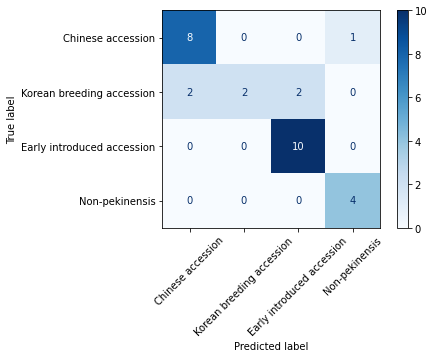

In [93]:
with tf.device('/CPU'):
    # print(train_image.image_shape)
    save_model = save_dir + '/best_model_cabbage.h5'
    mc = ModelCheckpoint(save_model, monitor='val_loss', mode='min', save_best_only=True)
    model = Func_model_2(image_all.image_shape)
    model = Func_model_opt(model, 0.0001)
    history = model.fit(x_train, y_train, epochs=1000, batch_size=1, verbose=1, validation_data=(x_val, y_val), callbacks=[es, mc])
    # model.summary()

    # prediction 결과
    val_loss, val_acc = model.evaluate(x_val, y_val)
    test_loss, test_acc = model.evaluate(x_test, y_test)
    print(val_acc, test_acc)

    result_pred = list(model.predict(x_test))
    # result_classes = list(model.predict_classes(x_test)) # 참고: https://leunco.tistory.com/16
    result_prob = model.predict(x_test)
    result_classes = result_prob.argmax(axis=-1)

    pd_tmp_result = pd.DataFrame(result_pred)
    pd_test_set = pd.DataFrame(test_set)
    pd_class = pd.DataFrame(result_classes)

    y_test_tmp = []
    for i in range(len(y_test)):
        if y_test[i, 0] == 1:
            y_test_tmp.append(0)
        elif y_test[i, 1] == 1:
            y_test_tmp.append(1)
        elif y_test[i, 2] == 1:
            y_test_tmp.append(2)
        else:
            y_test_tmp.append(3)

    # result save to jpg and csv
    pd_final_result = pd.concat([pd_test_set, pd_tmp_result, pd_class, pd.DataFrame(y_test_tmp)], axis=1)
    idx = list(image_all.class_indices)
    idx.insert(0, 'Sample')
    idx.append('Predict class')
    idx.append('Real class')
    pd_final_result.columns = idx
    pd_final_result.to_csv(save_dir_csv, header=True, index=False)

    cnf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model.predict(x_test), axis=1))
    disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=['Chinese accession', 'Korean breeding accession', 'Early introduced accession', 'Non-pekinensis'])
    disp = disp.plot(cmap=plt.cm.Blues, values_format='g', xticks_rotation='vertical')
    plt.xticks(rotation=45)
    plt.savefig(save_dir + '/CMYK_test_1_Confusion_matrix.jpg', dpi=400, bbox_inches='tight')